In [85]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, random, praw, csv, math
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
import re, urllib

from pathlib import Path
from datetime import datetime
import logging

utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/nathan/CivilServant"
FILE_BASE_DIR="/home/nathan/reddit_archive/"
sys.path.append(BASE_DIR)
subreddit_id = "2qr7i"

LOG_PATH = str(Path(BASE_DIR, "logs", "praw_messenger_%s.log" % ENV))
logging.basicConfig(filename=LOG_PATH, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

ARCHIVE_DIR = "/home/nathan/reddit_archive/03.2017"

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, and_, or_
from app.models import Base, SubredditPage, FrontPage, Subreddit, Post, ModAction, Experiment
from utils.common import PageType

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR)
r = conn.connect(use_db_keys=False)

#notebook_dir = os.getcwd()
#os.chdir(notebook_dir)
#import praw.errors


### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json


# Sample Recent r/iama posts and comments

In [86]:
query_text = """
select * from posts 
    WHERE subreddit_id = '2qzb6'
    AND created_at >= '2018-03-01'
    ORDER BY created ASC;
"""

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY

database_posts = []

for row in db_engine.execute(text(query_text)):
    post = {}
    post_data = json.loads(row['post_data'])
    for key in post_data.keys():
        post[key] = post_data[key]
    for key in row.keys():
        post[key]=row[key]
    
    lbody  = post['selftext'].lower()
    ltitle = post['title'].lower()
    post['AMA'] = False
    if(lbody.find("proof") > - 1 and ltitle.find("request") ==-1):
        post['AMA'] = True
        
    post['created'] = post['created']
    database_posts.append(post)
    
print("Loaded {0} Posts since March 1, 2018".format(len(database_posts)))
print("Loaded {0} AMA Posts".format(len([x for x in database_posts if x['AMA']])))

Loaded 1546 Posts since March 1, 2018
Loaded 602 AMA Posts


In [87]:
query_text = """
select * from comments 
    WHERE subreddit_id = '2qzb6'
    AND created_at >= '2018-03-01'
    ORDER BY created_utc ASC;
"""

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY

database_comments = []

for row in db_engine.execute(text(query_text)):
    comment = {}
    comment_data = json.loads(row['comment_data'])
    for key in comment_data.keys():
        comment[key] = comment_data[key]
    for key in row.keys():
        comment[key]=row[key]
    comment['created'] = comment['created_utc']
    database_comments.append(comment)
    
print("Loaded {0} Comments".format(len(database_comments)))

Loaded 139633 Comments


In [88]:
import datetime

recent_mod_actions = []
for row in db_engine.execute(text("""
SELECT action_data FROM mod_actions 
    WHERE subreddit_id="2qzb6" 
    AND created_utc >= "2018-03-01" 
    ORDER BY created_utc;
""")):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

28281 moderator actions loaded


In [89]:
all_posts = {}

for post in database_posts:
    if(post['AMA']):
        post['visible'] = True
        post['comments'] = []
        all_posts[post['id']]  = post

missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in all_posts.keys():
            if(key in all_posts.keys()):
                all_posts[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in all_posts.keys():
            if(key in all_posts.keys()):
                all_posts[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
#print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
#print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))
print("Visible AMAs: {0}".format(len([x for x in list(all_posts.values()) if x['AMA']])))

Matched Mod Actions: 457
Visible AMAs: 602


# Create a Per-Post Dataset of Comments, with Moderation Actions on Posts

In [90]:
total_comments_included = 0
total_questions_included = 0
for comment in database_comments:
    comment['toplevel'] = False
    comment['question'] = False
    if(comment['parent_id']==comment['link_id']):
        comment['toplevel'] = True
    if(comment['body'].find("?")>-1):
        comment['question'] = True
    post_id = comment['link_id'].replace("t3_","")
    if post_id in all_posts.keys():
        all_posts[post_id]['comments'].append(comment)
        total_comments_included += 1
        total_questions_included += 1*int(comment['question'])

for post_id, post in all_posts.items():
    post['comments'] = sorted(post['comments'], key = lambda x: x['created'])
    post['num.non.questions'] = len([x for x in post['comments'] if x['toplevel'] and x['question'] == False])
    post['num.questions'] = len([x for x in post['comments'] if x['toplevel'] and x['question'] == True ])
    
print("Total comments included: {0}".format(total_comments_included))
print("Total non-questions included: {0}".format(total_comments_included - total_questions_included))

Total comments included: 98376
Total non-questions included: 57077


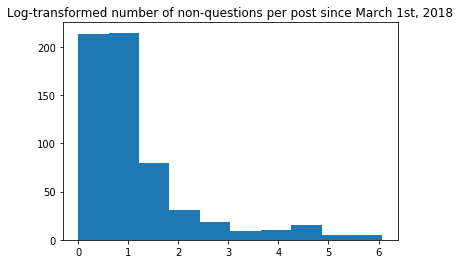

In [91]:
plt.hist([math.log1p(x['num.non.questions']) for x in all_posts.values()])
plt.title("Log-transformed number of non-questions per post since March 1st, 2018")
plt.show()

## CREATE A STRATIFIED SAMPLE OF AMA GUESTS

In [92]:
list(all_posts.values())[0]['visible']

True

In [93]:
def ama_guest():
    return {"author":None,
            "date": None,
            "num.comments":None,
            "num.questions": 0,
            "num.non.questions":0,
            "post.visible": False,
            "title": None}

ama_guests = defaultdict(ama_guest)

counter = 0
for post_id, post in all_posts.items():
    guest = ama_guest()
    guest['author'] = post['author']
    guest['title'] = post['title']
    guest['date'] = post['created']
    guest['num.comments'] = len(post['comments'])
    guest['num.questions'] = post['num.questions']
    guest['num.non.questions'] = post['num.non.questions']
    guest['pct.questions'] = post['num.questions'] / (post['num.questions'] + post['num.non.questions'] + 1 )
    guest['post.visible'] = post['visible']
    ama_guests[guest['author']]  = guest
    counter += 1
    
print(counter)


602


In [94]:
Counter([x['post.visible'] for x in list(ama_guests.values())])

Counter({False: 148, True: 399})

(array([ 83.,   0.,   5.,   5.,   1.,  29.,  33.,  56., 116.,  71.]),
 array([0.        , 0.0993865 , 0.19877301, 0.29815951, 0.39754601,
        0.49693252, 0.59631902, 0.69570552, 0.79509202, 0.89447853,
        0.99386503]),
 <a list of 10 Patch objects>)

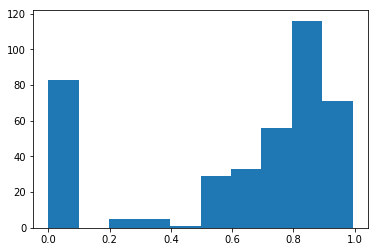

In [95]:
plt.hist([x['pct.questions'] for x in list(ama_guests.values()) if x['post.visible']] )

### Label comments by how many weeks previously the AMA was held (for a stratified random sample)

In [96]:
import datetime
one_week_in_seconds = 60*60*24*7
current_time = datetime.datetime.utcnow()

for guest_id, guest in ama_guests.items():
    guest['ama.week.diff'] = int((current_time - guest['date']).total_seconds() / 
                                             one_week_in_seconds)
    
    
    

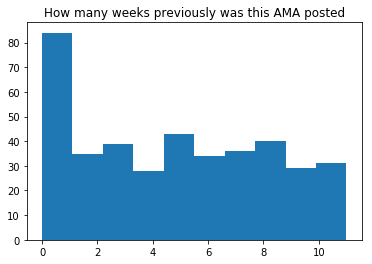

In [97]:
plt.hist([guest['ama.week.diff'] for guest in ama_guests.values() if guest['post.visible']])
plt.title("How many weeks previously was this AMA posted")
plt.show()

### Create a stratified random sample of accounts to message, based on the elapsed number of weeks since they originally posted their AMA
The purpose of this is to get response rates based on how recently they did the AMA. Note that we will want to include them int he sample even if their account doesn't exist, because we're going to be including those kinds of accounts in the study, and we will want to think about that attrition as an expected part of the sample.

In [98]:
eligible_by_week = {}
for key in set([x['ama.week.diff'] for x in ama_guests.values()]):
    eligible_by_week[key] = [x for x in ama_guests.values() if 
                             x['ama.week.diff'] == key and x['post.visible']]

In [99]:
for key in sorted(eligible_by_week.keys()):
    print("Week age {0}: {1} authors ".format(key, len(eligible_by_week[key])))

Week age 0: 48 authors 
Week age 1: 36 authors 
Week age 2: 35 authors 
Week age 3: 39 authors 
Week age 4: 28 authors 
Week age 5: 43 authors 
Week age 6: 34 authors 
Week age 7: 36 authors 
Week age 8: 40 authors 
Week age 9: 29 authors 
Week age 10: 28 authors 
Week age 11: 3 authors 


In [100]:
##  Decision: create a random sample of 40 people per week
##  Only survey the last 6 weeks
random.seed(880442) # current milliseconds at code time
sample_size = 27
selected_by_week_dict = {}
selected_by_week = {}
for week in sorted(eligible_by_week.keys()):
    if week <=7:
        selected_by_week_dict[week] = random.sample(eligible_by_week[week], sample_size)
        selected_by_week[week] = [x['author'] for x in selected_by_week_dict[week]]
        
for week in sorted(selected_by_week.keys()):
    print("Week age {0}: {1} authors ".format(week, len(selected_by_week_dict[week])))

Week age 0: 27 authors 
Week age 1: 27 authors 
Week age 2: 27 authors 
Week age 3: 27 authors 
Week age 4: 27 authors 
Week age 5: 27 authors 
Week age 6: 27 authors 
Week age 7: 27 authors 


In [101]:
selected_by_week[0][2]

'Danejasper'

### Create CSV of Authors to Reach

In [103]:
all_guests = []
for week, guests in selected_by_week_dict.items():
    all_guests += guests

In [104]:
#pd.DataFrame(all_guests).to_csv("iama/all_survey_pilot_guests-04.23.2018.csv")

# Construct and personalize the message
### Construct the Message Template

In [71]:
MESSAGE_SUBJECT = "Help r/IAmA understand your AMA experience with 5 questions"
MESSAGE_TEMPLATE = """Dear {username},

Hello and welcome from r/IAmA! Might you answer a 5 minute, 5 question survey about your experience hosting an Ask Me Anything?

The moderators of the IAMA subreddit have partnered with researchers learn ways to improve the Ask Me Anything experience. [CivilServant](http://civilservant.io/) is a project at Princeton University that helps online communities do research for a more understanding internet.

**[Learn more and answer the survey here]({url})**. We hope it will allow us to improve the AMA hosting experience in the future.

Thanks,

The [IAmA Moderator Team](https://www.reddit.com/r/iama/about/moderators) and [CivilServant](https://civilservant.io)
"""

In [72]:
print(MESSAGE_TEMPLATE.format(username="natematias", 
                              url="https://docs.google.com/forms/d/e/1FAIpQLSefInEC-wFI7KKQUq1TnTYYuC9FmqbLEflW9z9fe0rh99qzAA/viewform?usp=pp_url&entry.56120278={username}&entry.67846837&entry.1506827807".format(
                              username="natematias")))

Dear natematias,

Hello and welcome from r/IAmA! Might you answer a 5 minute, 5 question survey about your experience hosting an Ask Me Anything?

The moderators of the IAMA subreddit have partnered with researchers learn ways to improve the Ask Me Anything experience. [CivilServant](http://civilservant.io/) is a project at Princeton University that helps online communities do research for a more understanding internet.

**[Learn more and answer the survey here](https://docs.google.com/forms/d/e/1FAIpQLSefInEC-wFI7KKQUq1TnTYYuC9FmqbLEflW9z9fe0rh99qzAA/viewform?usp=pp_url&entry.56120278=natematias&entry.67846837&entry.1506827807)**. We hope it will allow us to improve the AMA hosting experience in the future.

Thanks,

The [IAmA Moderator Team](https://www.reddit.com/r/iama/about/moderators) and [CivilServant](https://civilservant.io)



# Methods for validating users and sending messages

In [73]:
def get_reddit_user(username):
    try:
        user_dict = r.get_redditor(username, fetch=True).json_dict
        logging.info("User %s found: %s" %(username, str(user_dict)))
        return user_dict
    except praw.errors.NotFound as e:
        logging.error("User not found: %s" % username)
    except Exception as e:
        logging.exception("Failed to retrieve user")
        
import time
## ADD LINE TO THE FILE BEFORE RUNNING
# username,exists,date,deleted,url,first_comment_week,sent_status
send_log_dir = "/home/nathan/CivilServant-Analysis/SOC412/iama"
send_log_filename = "message_sender_iama_04_23_2018.csv"

def sent_message_previously(username):
    if(os.path.isfile(os.path.join(send_log_dir, send_log_filename))!=True):
        return False
    with open(os.path.join(send_log_dir, send_log_filename), "r") as f:
        send_log = []
        for row in csv.DictReader(f):
            send_log.append(row)
            if(username == row['username']):
                return True
    return False

In [74]:
## RETURN TRUE IF MESSAGE WAS SENT SUCCESSFULLY
def send_reddit_message(**message_data):
    user = message_data["username"]    
    message = MESSAGE_TEMPLATE.format(**message_data)    
    try:
        logging.info("Sending a message to user %s with data %s" % (user, str(message_data)))
        response = r.send_message(user, MESSAGE_SUBJECT, message, raise_captcha_exception=True)
        response = []
        if response["errors"]:
            logging.error("Error in response when sending a message to user %s: %s" % (user, str(response)))
            return False
        else:
            logging.info("Message successfully sent to user %s" % user)
            return True
    except praw.errors.InvalidCaptcha as e:
        logging.exception("Message sending requires a captcha")
        logging.error(e.response)
        return False
    except Exception as e:
        logging.exception("Failed to send message to %s" % user)
        return False

In [75]:
def send_survey_message(**message_data):
    message = MESSAGE_TEMPLATE.format(**message_data)        
    sent_status = send_reddit_message(**message_data)
    with open(os.path.join(send_log_dir,send_log_filename), "a") as f:
        print("APPENDING TO FILE: {0}".format(message_data))
        f.write(",".join(map(str, [
            message_data['username'],
            True, #account exists
            message_data['get_info_date'],
            message_data['deleted'],
            message_data['url'],
            message_data['first_comment_week'],
            sent_status
        ])) + "\n")
        f.close()
    
    logging.info("first_comment_week: %s" % message_data["first_comment_week"])
    logging.info("url: %s" % message_data["url"])
    logging.info("get_info_data: %s" % message_data["get_info_date"])
    logging.info("deleted: %s" % message_data["deleted"])
    return message
    

In [76]:
import datetime
def decide_and_send_to_user(username, first_comment_week):
    if(sent_message_previously(username)):
        logging.info("User %s previously received a message" % username)
        return None
    else:
        time.sleep(2)
        user = get_reddit_user(username)

    if user:
        send_survey_message(
            username = username,
            first_comment_week = first_comment_week,
            get_info_date = str(datetime.datetime.utcnow()),
            deleted = False,
            url = "https://docs.google.com/forms/d/e/1FAIpQLSefInEC-wFI7KKQUq1TnTYYuC9FmqbLEflW9z9fe0rh99qzAA/viewform?usp=pp_url&entry.56120278={username}&entry.67846837&entry.1506827807".format(
                username=username))
    else:
        with open(os.path.join(send_log_dir, send_log_filename), "a") as f:
            f.write(",".join(map(str, [
                username,
                False,
                str(datetime.datetime.utcnow()),
                None,
                None,
                first_comment_week,
                False
            ])) + "\n")
            f.close()

# Send Survey to Participants

In [ ]:
# import time
# for week in sorted(selected_by_week.keys()):
#     print("Week age {0}: {1} authors ".format(week, len(selected_by_week[week])))
#     for username in selected_by_week[week]:
#         decide_and_send_to_user(username, week)

# Create a Moderated Posts Dataset

In [161]:
posts_to_file = []
for post in all_posts.values():
    post = copy.copy(post)
    del post['post_data']
    del post['selftext']
    del post['selftext_html']
#    del post['title']
    del post['comments']
    if 'body' in post.keys():
        del post['body']
    if 'preview' in post.keys():
        del post['preview']
    posts_to_file.append(post)

In [162]:
#list(all_posts.values())[0]
#x = pd.DataFrame(posts_to_file)

In [163]:
pd.DataFrame(posts_to_file).to_csv("iama/posts_with_mod_actions.csv")

In [148]:
#plt.hist([x['num.non.questions'] for x in posts_to_file])

In [150]:
#
Counter(['num.non.questions' in x.keys() for x in posts_to_file])

Counter({True: 602})

In [159]:
posts_to_file[0]

{'AMA': True,
 'approved': False,
 'approved_at_utc': None,
 'approved_by': None,
 'archived': False,
 'author': 'irdk_',
 'author_flair_background_color': None,
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_text': None,
 'author_flair_text_color': None,
 'author_flair_type': 'text',
 'banned_at_utc': None,
 'banned_by': None,
 'brand_safe': True,
 'can_gild': True,
 'can_mod_post': False,
 'clicked': False,
 'comment_data': None,
 'comments_queried_at': None,
 'contest_mode': False,
 'created': datetime.datetime(2018, 4, 5, 13, 32, 8),
 'created_at': datetime.datetime(2018, 4, 5, 17, 36),
 'created_utc': 1522949528.0,
 'distinguished': None,
 'domain': 'self.IAmA',
 'downs': 0,
 'edited': False,
 'gilded': 0,
 'hidden': False,
 'hide_score': False,
 'id': '8a1pp9',
 'ignore_reports': False,
 'is_crosspostable': True,
 'is_reddit_media_domain': False,
 'is_self': True,
 'is_video': False,
 'likes': None,
 'link_flair_css_class': None,
 'link_flair_richte

In [167]:
removed_comments = [x for x in recent_mod_actions if x['action']=='removecomment']

In [169]:
removed_comments[1]

{'action': 'removecomment',
 'created': datetime.datetime(2018, 3, 1, 5, 2, 46, tzinfo=<UTC>),
 'created_utc': 1519880566.0,
 'description': None,
 'details': 'Not question',
 'id': 'ModAction_c837e75e-1d0d-11e8-8a34-0aec3593d7ba',
 'mod': 'AutoModerator',
 'mod_id36': '6l4z3',
 'sr_id36': '2qzb6',
 'subreddit': 'IAmA',
 'subreddit_name_prefixed': 'r/IAmA',
 'target_author': 'goofygoober2',
 'target_body': 'Smh....what a disgusting thread ',
 'target_fullname': 't1_dv02ii1',
 'target_permalink': '/r/IAmA/comments/80y3va/im_an_ex_white_supremacist_and_klansman_ama/dv02ii1/',
 'target_title': None}